# 0. Import Packages

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras_preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras import layers
from keras.src.layers.core.dense import Dense
from keras.src.layers.reshaping.flatten import Flatten
from keras.src.layers.rnn.lstm import LSTM
from keras.src.layers.rnn.rnn import RNN
from keras.src.optimizers.rmsprop import RMSprop
from keras.src.callbacks.early_stopping import EarlyStopping
from keras.src.callbacks.model_checkpoint import ModelCheckpoint
from keras.src.models.model import model_from_json
from keras import optimizers

# 1. Load data

In [128]:
# 온도 선택 [N10, 0, 10, 20, 25, 30, 40, 50], temp 변수에 설정

temp = 'N10'
mode = ['DST', 'FUDS' ,'US06']
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

for m in mode:
    data_dir = os.path.join(parent_dir, f'DB Preprocessing/refined_data/{temp}/{m}')
    file_names = os.listdir(data_dir)
    for file_name in file_names:
        csv_dir = os.path.join(data_dir, file_name)
        if '007' in file_name:
            num = '007'
        else: 
            num = '008'
        globals()['csv_{}'.format(f'{m}_{num}')] = pd.DataFrame(pd.read_csv(csv_dir))
        print(f'csv_{m}_{num} 생성 완료')

csv_DST_007 생성 완료
csv_DST_008 생성 완료
csv_FUDS_007 생성 완료
csv_FUDS_008 생성 완료
csv_US06_007 생성 완료
csv_US06_008 생성 완료


In [129]:
csv_DST_007

,Current(A),Voltage(V),Temperature (C)_1,SoC
0,0.000191,3.526907,-8.332584,80.000000
1,0.000191,3.526599,-8.565621,80.000000
2,0.000191,3.526291,-8.332584,80.000000
3,0.000003,3.525676,-8.332584,80.000000
4,0.000378,3.525984,-8.332584,80.000000
...,...,...,...,...
5279,-0.480845,2.945211,-7.249700,0.356594
5280,-3.849219,2.086517,-7.094693,0.275559
5281,-3.849219,2.045275,-7.094693,0.176988
5282,-3.849219,2.017267,-6.985489,0.079046


# 2. V, I, T / SoC 분리 

In [130]:
num = ['007','008']

def df2numpy(df):
    np = df.values
    return np

for m in mode:
    for n in num:
        var_name = f'csv_{m}_{n}'
        csv = globals()[var_name]
        globals()[f'input_{m}_{n}'] = df2numpy(csv[['Current(A)', 'Voltage(V)', 'Temperature (C)_1']])
        print(f'input_{m}_{n} 생성 완료')
        globals()[f'output_{m}_{n}'] = df2numpy(csv[['SoC']])
        print(f'output_{m}_{n} 생성 완료')

input_DST_007 생성 완료
output_DST_007 생성 완료
input_DST_008 생성 완료
output_DST_008 생성 완료
input_FUDS_007 생성 완료
output_FUDS_007 생성 완료
input_FUDS_008 생성 완료
output_FUDS_008 생성 완료
input_US06_007 생성 완료
output_US06_007 생성 완료
input_US06_008 생성 완료
output_US06_008 생성 완료


In [131]:
print(input_DST_007.shape)
input_DST_007

(5284, 3)


array([[ 1.90588195e-04,  3.52690697e+00, -8.33258438e+00],
       [ 1.90588195e-04,  3.52659917e+00, -8.56562138e+00],
       [ 1.90588195e-04,  3.52629137e+00, -8.33258438e+00],
       ...,
       [-3.84921932e+00,  2.04527473e+00, -7.09469271e+00],
       [-3.84921932e+00,  2.01726723e+00, -6.98548889e+00],
       [-3.84921932e+00,  1.99972391e+00, -7.09469271e+00]])

In [132]:
print(input_US06_008.shape)
input_US06_008

(3575, 3)


array([[-2.70769058e-04,  3.52535892e+00, -7.60126066e+00],
       [-9.03151522e-05,  3.52505112e+00, -7.52366018e+00],
       [-2.70769058e-04,  3.52474332e+00, -7.52366018e+00],
       ...,
       [-1.83855462e+00,  2.56849980e+00, -7.50607252e+00],
       [-3.31412601e+00,  2.14254522e+00, -7.42848539e+00],
       [-3.84556270e+00,  1.99912393e+00, -7.42848539e+00]])

# 3. Split train and test dataset

In [133]:
def create_dataset(input, output, look_back=1):
    dataX, dataY = [], []
    for i in range(len(input) - look_back + 1):
        a = input[i:(i + look_back)]
        dataX.append(a)
        dataY.append(output[i + look_back -1])
    dataY = np.reshape(dataY, (len(dataY), 1, 1))
    print(dataY.shape)
    return np.array(dataX), np.array(dataY)

a = [0,1,2,3,4,5,6,7,8,9]
b = [10,11,12,13,14,15,16,17,18,19]
x, y = create_dataset(a, b, 3)
print(x)
print(y)

(8, 1, 1)
[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]
 [7 8 9]]
[[[12]]

 [[13]]

 [[14]]

 [[15]]

 [[16]]

 [[17]]

 [[18]]

 [[19]]]


In [134]:
# look_back 변수 설정(자연수. 보통 20 설정.)
look_back = 20

dstX_7, dstY_7 = create_dataset(input_DST_007, output_DST_007, look_back)
dstX_8, dstY_8 = create_dataset(input_DST_008, output_DST_008, look_back)
us06X_7, us06Y_7 = create_dataset(input_US06_007, output_US06_007, look_back)
us06X_8, us06Y_8 = create_dataset(input_US06_008, output_US06_008, look_back)
fudsX_7, fudsY_7 = create_dataset(input_FUDS_007, output_FUDS_007, look_back)
fudsX_8, fudsY_8 = create_dataset(input_FUDS_008, output_FUDS_008, look_back)

print(dstX_7.shape)
print(dstY_7.shape)

(5265, 1, 1)
(3108, 1, 1)
(5081, 1, 1)
(3556, 1, 1)
(5651, 1, 1)
(2920, 1, 1)
(5265, 20, 3)
(5265, 1, 1)


# 4. Training with Linear Regression

In [135]:
model = Sequential()
model.add(Flatten(input_shape=(20, 3)))
model.add(Dense(64, input_dim = 5))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'])

c:\Users\ays99\Documents\2024 대학\1학기\캡디\project\SoC_capstone\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ays99\Documents\2024 대학\1학기\캡디\project\SoC_capstone\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [136]:
history_dst_7 = model.fit(dstX_7, dstY_7, epochs=100, batch_size=10, verbose=0)
history_us06_7 = model.fit(us06X_7, us06Y_7, epochs=100, batch_size=10, verbose=0)
history_dst_8 = model.fit(dstX_8, dstY_8, epochs=100, batch_size=10, verbose=0)
history_us06_8 = model.fit(us06X_8, us06Y_8, epochs=100, batch_size=10, verbose=0)

In [140]:
# save model architecture
model_dir = os.path.join(current_dir, 'model', temp)
model_json = model.to_json()
open(f'{model_dir}/{temp}_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights(f'{model_dir}/{temp}.weights.h5', overwrite=True)

In [142]:
# Load trained model
json_file = open(f'{model_dir}/{temp}_model.json', "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# model weight load 
loaded_model.load_weights(f'{model_dir}/{temp}.weights.h5')
print("Loaded model from disk")

Loaded model from disk


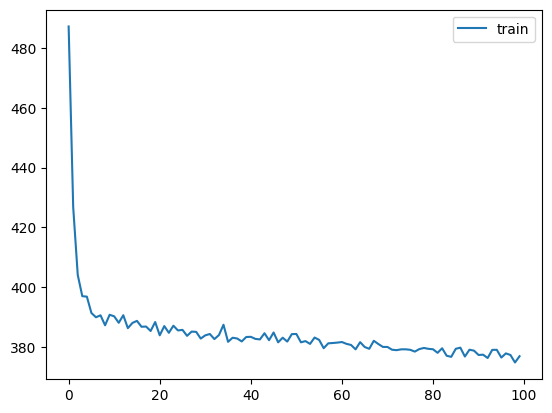

In [154]:
plt.plot(history_dst_7.history['loss'], label='train')

plt.legend() 
plt.show()

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(5651, 1)
(5651, 1)


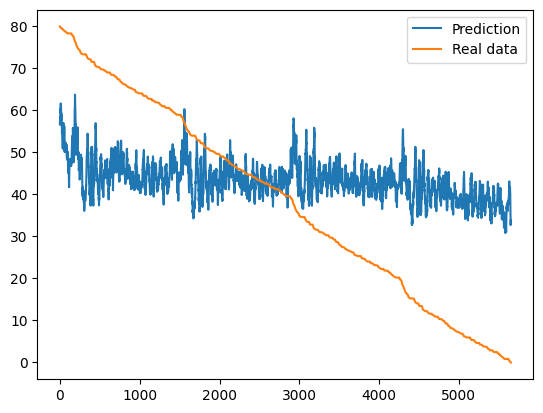

In [158]:
fudsY_7_hat = model.predict(fudsX_7)
fudsY_7 = np.reshape(fudsY_7, (fudsY_7.shape[0], 1))
plt.plot(fudsY_7_hat, label='Prediction')
plt.plot(fudsY_7, label='Real data')
plt.legend()
plt.show()

In [159]:
rmse = math.sqrt(mean_squared_error(fudsY_7, fudsY_7_hat))
mae = mean_absolute_error(fudsY_7, fudsY_7_hat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 21.534
Test MAE: 18.668


# 4. Visualization